In [188]:
# Imports.
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import MinMaxScaler
# from templates.constants import N_JOBS
from sklearn.metrics import accuracy_score
import os
import itertools
from sklearn.metrics import make_scorer

In [189]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

# Ground Truth

In [190]:
y_cheat = pd.read_csv('../data/Cheat.csv', index_col=0)
index = y_cheat.index
y_true = y_cheat['SalePrice']
y_true

Id
1461    105000
1462    172000
1463    189900
1464    195500
1465    191500
         ...  
2915     90500
2916     71000
2917    131000
2918    132000
2919    188000
Name: SalePrice, Length: 1459, dtype: int64

Only encoded data

In [191]:
model_names = ['MeanEnc', 'RidgeRegression', 'Scaled']
# metrics = ['Accuracy', 'Precision']
# types = ['All', 'Mean_encoded', 'Initial']

In [192]:
def load_data(model_names, columns):
    for model_name in model_names:
        path = f'{model_name}.csv'
        if os.path.exists(path):
            df = pd.read_csv(path, delimiter=',', index_col='Id')
            columns[model_name] = df['SalePrice']
    return columns
columns = dict()
columns = load_data(model_names, columns=columns)
columns
# columns = load_data(model_names, encoded=types, columns=columns, train=True,
#                     metrics=metrics, sample_suffix='')
predictions = pd.DataFrame(columns, index=index)
predictions['SalePrice'] = y_true

In [193]:
# train_data['Survived'] = y_true

In [194]:
def pred_correlation(df, proba=False):
    corr = df.corr()
    if 'SalePrice' in df.columns:
        sorted_index = \
            corr['SalePrice'].apply(np.abs).sort_values(ascending=False).index
        sorted_corr = corr[sorted_index].reindex(sorted_index)
        sorted_corr.head()
    else:
        sorted_corr = corr
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(sorted_corr, ax=ax, annot=True, fmt='.2f')
    ax.set_title('Most correlated features.')
    plt.tight_layout();
pred_correlation(predictions)

# Check individual model scores

In [195]:
def rmsle(y, y_pred):
    if len(y) != len(y_pred):
        return 0
    sum = 0
    for real, pred in zip(y, y_pred):
        if real < 0:
            real = 0,
        if pred < 0:
            pred = 0
        p = np.log(real + 1)
        r = np.log(pred + 1)
        sum += np.square(p - r)
    result = np.sqrt(sum / len(y_pred))
    if isinstance(result, np.ndarray):
        result = result[0]
    return result
    
scores = dict()
for column in predictions.columns:
    scores[column] = rmsle(y_true, predictions[column])

scores_df = pd.DataFrame({'Scores': scores.values()},
                         index=scores.keys())
scores_df.sort_values('Scores', inplace=True, ascending=False)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(scores_df, ax=ax, annot=True, fmt='.4f');

In [196]:
my_scorer = make_scorer(rmsle, greater_is_better=False)
lr = LinearRegression(fit_intercept=False)
X = predictions[model_names]
y = predictions['SalePrice']
cross_val_score(lr, X, y, scoring=my_scorer).mean()

-0.11622065303807212

In [197]:
lr.fit(X, y).coef_

array([0.47939979, 0.37327598, 0.16327837])

In [198]:
predictions

,MeanEnc,RidgeRegression,Scaled,SalePrice
Id,,,,
1461,104293.578125,106729.292147,128603.260,105000
1462,144802.406250,166267.488636,159841.600,172000
1463,187632.421875,183740.292746,189608.060,189900
1464,193777.781250,203890.307116,198563.140,195500
1465,198880.046875,197880.472675,191973.860,191500
...,...,...,...,...
2915,84702.515625,84451.907073,84168.664,90500
2916,86647.414062,86318.535865,82488.520,71000
2917,173694.703125,170067.854032,151841.500,131000


In [199]:
predictions['Submission'] = predictions['MeanEnc'] * 0.5 \
                            + predictions['RidgeRegression'] * 0.32 \
                            + predictions['Scaled'] * 0.18

In [200]:
def generate_submission(preds, index):
    submission_df = pd.DataFrame({'Id': index,
                                'SalePrice': preds})
    submission_df.to_csv('./EnsembleSubmission.csv', index=False)
    print('Ready')
generate_submission(predictions['Submission'].astype(int), index)

Ready


# Use model for submission

In [201]:
def compare_preds(pred1, pred2):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlabel(pred1.name)
    ax.set_ylabel(pred2.name)
    ax.scatter(pred1, pred2, c=y_true, cmap='bwr')
    plt.show()

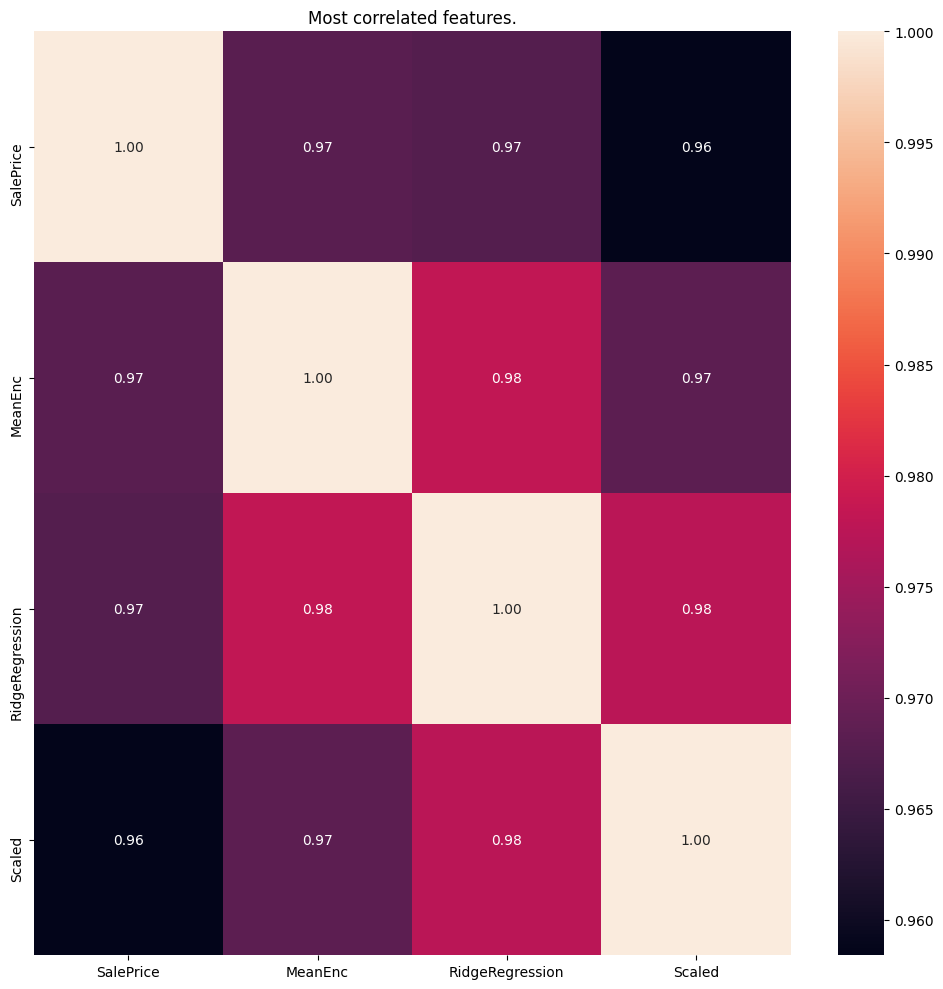

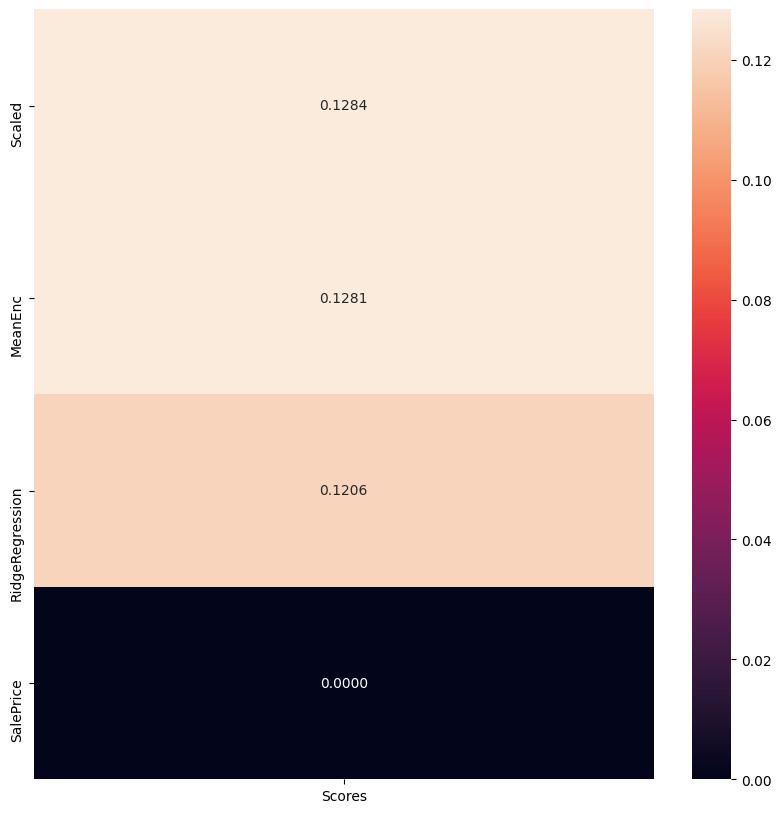

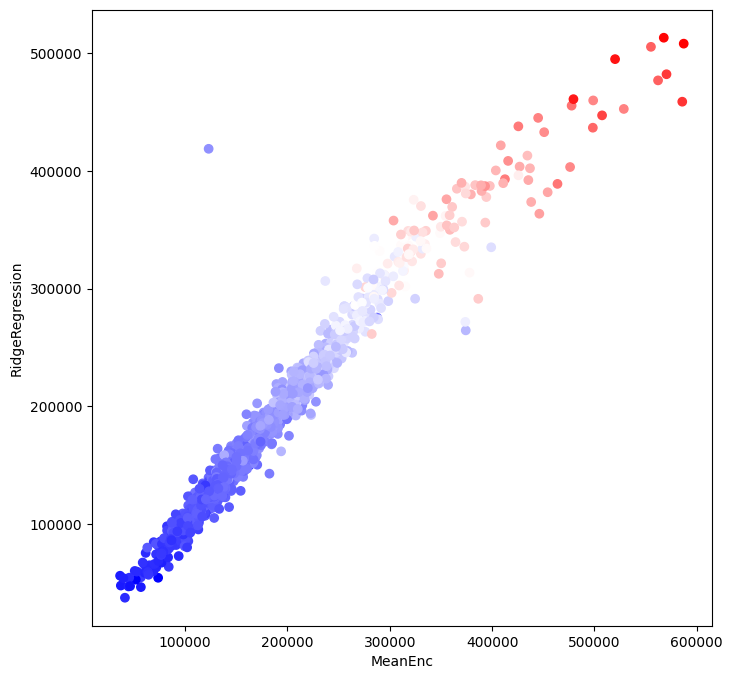

In [202]:
compare_preds(predictions['MeanEnc'], predictions['RidgeRegression'])

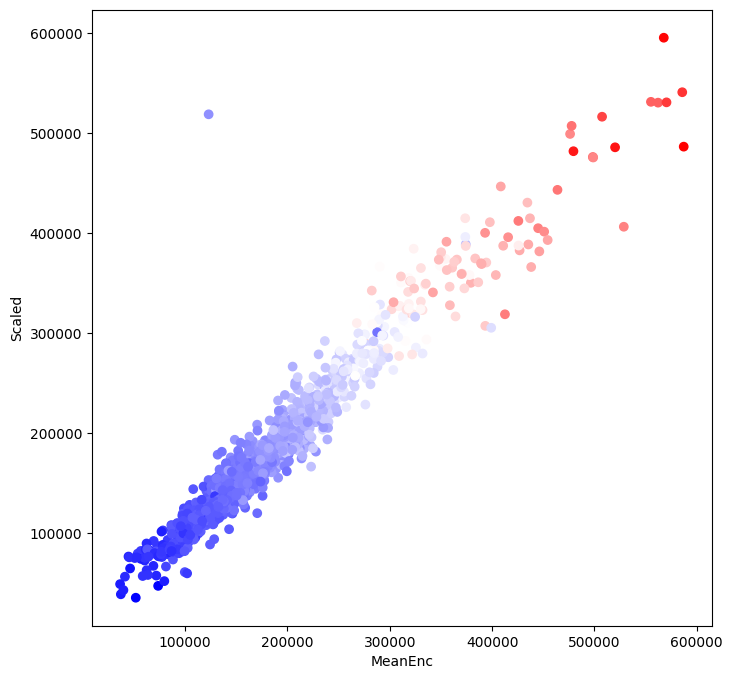

In [203]:
compare_preds(predictions['MeanEnc'], predictions['Scaled'])

In [204]:
rmsle(y_true, predictions['Submission'])

0.11678012881506909

In [205]:
my_scorer = make_scorer(rmsle, greater_is_better=False)
lr = LinearRegression(fit_intercept=False)
X = predictions[['Scaled', 'RidgeRegression']]
y = predictions['SalePrice']
cross_val_score(lr, X, y, scoring=my_scorer).mean()

-0.11588140826678783

In [206]:
lr.fit(X, y).coef_

array([0.29652997, 0.71656932])

In [207]:
predictions['Submission2'] = predictions['Scaled'] * 0.3 \
                            + predictions['RidgeRegression'] * 0.7

In [208]:
def generate_submission(preds, index):
    submission_df = pd.DataFrame({'Id': index,
                                'SalePrice': preds})
    submission_df.to_csv('./EnsembleSubmission.csv', index=False)
    print('Ready')
generate_submission(predictions['Submission2'].astype(int), index)

Ready


In [209]:
rmsle(y_true, predictions['Submission2'])

0.11587570858446723